<a href="https://colab.research.google.com/github/SamiraAsadzadeh/HomeWork_DeepLearning/blob/main/TransferLearning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **By: Samira Asadzadeh  40116341054541**

*   **Advisor:  Dr. Mr.Asadi**

*  **ISLAMIC AZAD UNIVERSITY SHIRAZ BRANCH Faculty of engineering**



# **VGG**

In [ ]:
#!pip install torch
!#pip install torchvision
!pip install scikit-plot

#Import Library

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import itertools
from sklearn.metrics import confusion_matrix
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import cross_val_score
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import scikitplot as skplt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from functools import partial
import random
from concurrent import futures
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
from matplotlib import pyplot
from pylab import *
from keras.preprocessing.image import ImageDataGenerator
from numpy import save
from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from numpy import set_printoptions
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

#Connect Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

#!ls 'drive/My Drive'

Mounted at /content/drive


# Data

In [ ]:
trn_dir = '/content/drive/MyDrive/HomeWork deep learning/5/DataSet'
sz = 224
batch_size = 32
os.listdir(trn_dir)

['Benign', 'malignant']

In [ ]:
Benign_=glob.glob('/content/drive/MyDrive/HomeWork deep learning/5/DataSet/Benign/*.jpg')
Benign_ = len(Benign_)
malignant_=glob.glob('/content/drive/MyDrive/HomeWork deep learning/5/DataSet/malignant/*.jpg')
malignant_ =len(malignant_)

my_dict = {
    'Targets': ["Benign", "malignant"],
    'Count': [Benign_ , malignant_]

}

df = pd.DataFrame(my_dict, index=[0,1])
df.tail()

,Targets,Count
0,Benign,399
1,malignant,395


# Data.Clases






In [ ]:
train_ds = datasets.ImageFolder(trn_dir)
train_ds.classes
train_ds.class_to_idx

{'Benign': 0, 'malignant': 1}

# Transformations






In [ ]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
len(train_ds)

794

##Create Training and Validation and Testing

In [ ]:
#train_D, test_set = train_test_split(train_ds, test_size=0.15, random_state=42)
train_set = int(0.7 * len(train_ds))
mean = int(len(train_ds) - train_set)/2
val_set = int(mean)+1
test_set = int(mean)
train_set, val_set, test_set = torch.utils.data.random_split(train_ds, [train_set, val_set, test_set])
len(train_set), len(val_set), len(test_set)
print(('Train:', len(train_set)), ('Test:', len(test_set)),('Validation:', len(val_set)))

('Train:', 555) ('Test:', 119) ('Validation:', 120)


# Dataloaders

In [ ]:
#train_D = torch.utils.data.DataLoader(train_D,
                                      # shuffle=True, num_workers=8)

train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                       shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                       shuffle=True, num_workers=8)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                       shuffle=True, num_workers=8)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Visualise image

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)



###Random images from training data

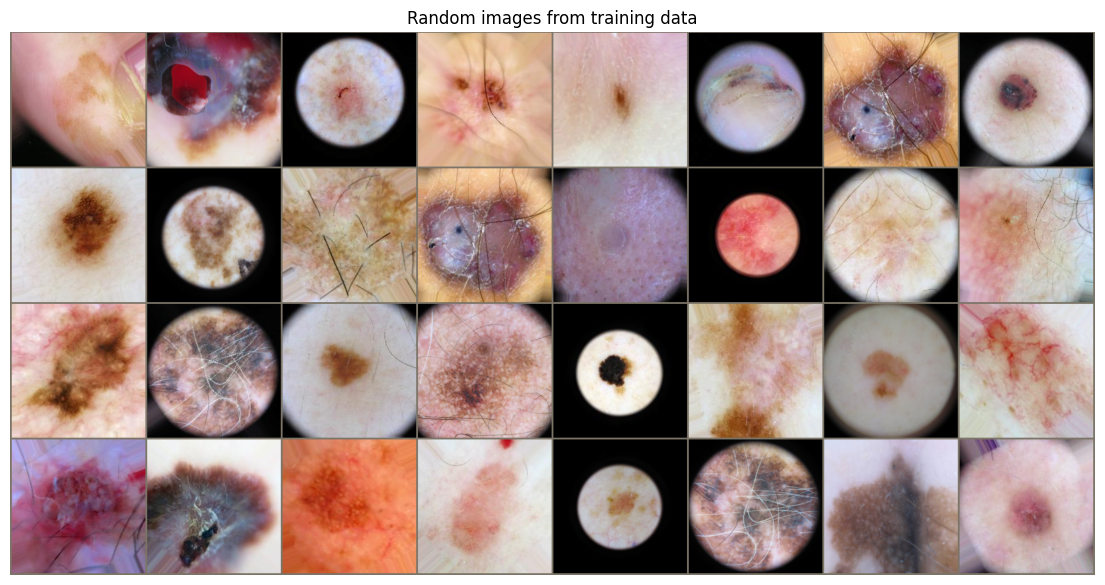

In [ ]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(14, 14))
imshow(out, title='Random images from training data')

In [ ]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Downloading the VGG16 Network


In [ ]:
vgg16 = models.vgg16(pretrained=True)
# The argument pretrained=True implies to load the ImageNet weights for the pre-trained model.
vgg16.to(device)
#print(vgg16)
summary(vgg16, (3, 224, 224))
#vgg16.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.4MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Freezing Convolution Weights



بلوک کد زیر تغییرات لازم را برای طبقه بندی کلاس 2 همراه با فریز کردن وزن ها ایجاد می کند.


In [ ]:
# change the number of classes
vgg16.classifier[6].out_features = 2
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

# Optimizer and Loss Function
We will use the CrossEntropyLoss() and SGD() optimizer

In [ ]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# Training and Validation Functions


In [ ]:
# validation function
def predict_class(model, val_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(val_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)

        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()


    val_loss = val_running_loss/len(val_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(val_dataloader.dataset)
    print(f'Validation Loss: {val_loss:.2f}, Validation Acc: {val_accuracy:.2f}' )

    return val_loss, val_accuracy

In [ ]:
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)


        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')



    #print('Epoch [%2d/%2d], Train loss: %.4f, Val_loss: %.4f, Train Acc, vall Acc: %.4f'
                  # % (epoch + 1, train_loss, val_loss, train_accuracy, val_accuracy ))
    return train_loss, train_accuracy

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
#y_pred , y_true = [], []

num_epochs = 2
start = time.time()
for epoch in range(num_epochs):

    train_epoch_loss, train_epoch_accuracy = fit(vgg16, train_dl)
    val_epoch_loss, val_epoch_accuracy = predict_class(vgg16, valid_dl)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)


    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60,  'minutes')

Train Loss: 0.0025, Train Acc: 97.84
Validation Loss: 0.01, Validation Acc: 85.83
Train Loss: 0.0017, Train Acc: 98.92
Validation Loss: 0.01, Validation Acc: 85.00
0.30618991057078043 minutes


In [ ]:
test_epoch_loss, test_epoch_accuracy = predict_class(vgg16, test_dl)

Validation Loss: 0.01, Validation Acc: 89.08


# Visualizing the Plots

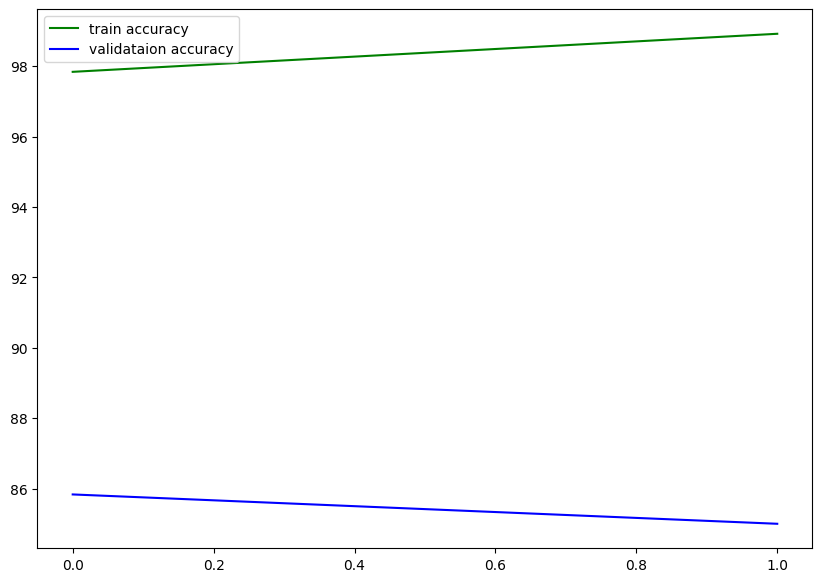

In [ ]:
#Training and Validation Accuracy Plot
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

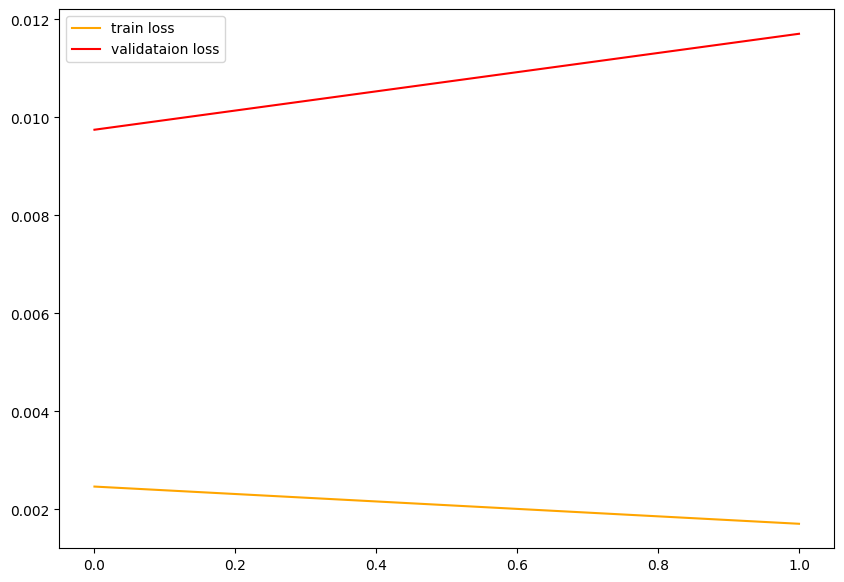

In [ ]:
#Training and Validation Loss Plot
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()



---



---



---

